In [222]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
from simpy_helpers import Source, Resource , Stats, Entity
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation
import random

## Arrival at the Port:

- The ship arrives, and the function records the current time (`arrival_time`) and converts it to a real-world date (`real_arrival_time`).
- It logs the size of the queues at different berths.
- The type of ship and cargo are identified.

## Waiting for Daylight (Night Wait):

- If the ship arrives at night (before 8 AM or after 8 PM), it must wait until 8 AM.
- The function calculates how long the ship needs to wait until daytime.

## Berth Request:

- The ship requests a berth (a place to dock). It waits in the queue if a berth is not available.
- The function checks if meteorological conditions allow the ship to proceed.

## Meteorological Check (Every 3 Hours):

- The ship must wait until favorable meteorological conditions are met. This is checked every 3 hours.

## Waiting Time Calculations:

- The time spent waiting for the meteorological check (`mc_waiting_time`), the time waiting for a berth (`berth_waiting_time`), and the total waiting time are calculated and logged.

## Loading Process:

- After passing the meteorological check and getting a berth, the ship starts loading cargo.
- It checks if there’s enough cargo in storage. If not, it waits for a refill.
- The function simulates the loading process using a random distribution for pre-service, processing, and post-service times.

## Departure:

- After loading, the ship releases the berth and departs.
- The function logs all relevant data, such as arrival time, loading time, waiting time, total time spent in the port, and cargo loaded.


In [82]:
def time_to_minutes(time_str):
    """Convert HH:MM time format to total minutes."""
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

def minutes_to_time(minutes):
    """Convert total minutes to HH:MM time format."""
    hours = minutes // 60
    minutes = minutes % 60
    return f"{hours}:{minutes:02}"

def average_time(time_list):
    """Calculate the average time from a list of HH:MM time strings."""
    total_minutes = sum(time_to_minutes(time) for time in time_list)
    average_minutes = total_minutes / len(time_list)
    return minutes_to_time(int(average_minutes))

def format_time( sim_time):
    hours = int(sim_time)
    minutes = int((sim_time - int(sim_time)) * 60)
    return f"{hours}:{minutes:02}"

def time_date(year , month , day , hour , minute =0):
    current_time = datetime(year, month, day, hour)
    current_time = f"{current_time.year}-{current_time.month:02d}-{current_time.day:02d} {hour}:{minute:02d}"
    return current_time
def get_closest_time(current_time):
    """
    Get the closest time to the current time where the hour is a multiple of 3 and the minutes are zero.
    
    Parameters:
    current_time (datetime): The current time.
    
    Returns:
    datetime: The closest time with hour % 3 == 0 and minutes == 0.
    """
    current_hour = current_time.hour
    next_hour = (current_hour // 3 + 1) * 3 if current_hour % 3 != 0 else current_hour
    if next_hour == 24:
        next_hour = 0
        current_time += timedelta(days=1)
    closest_time = current_time.replace(hour=next_hour, minute=0, second=0, microsecond=0)
    return closest_time
def get_closest_time(current_time):
    """
    Get the closest time to the current time where the hour is a multiple of 3 and the minutes are zero.
    
    Parameters:
    current_time (datetime): The current time.
    
    Returns:
    datetime: The closest time with hour % 3 == 0 and minutes == 0.
    """
    current_hour = current_time.hour
    
    # Calculate the next closest time
    next_hour = (current_hour // 3 + 1) * 3 if current_hour % 3 != 0 else current_hour
    if next_hour == 24:
        next_hour = 0
        next_time = (current_time + timedelta(days=1)).replace(hour=next_hour, minute=0, second=0, microsecond=0)
    else:
        next_time = current_time.replace(hour=next_hour, minute=0, second=0, microsecond=0)
    
    # Calculate the previous closest time
    prev_hour = (current_hour // 3) * 3 if current_hour % 3 != 0 else current_hour - 3
    if prev_hour < 0:
        prev_hour = 21
        prev_time = (current_time - timedelta(days=1)).replace(hour=prev_hour, minute=0, second=0, microsecond=0)
    else:
        prev_time = current_time.replace(hour=prev_hour, minute=0, second=0, microsecond=0)
    
    # Determine which of the two times is closer to the current time
    if abs((current_time - prev_time).total_seconds()) <= abs((next_time - current_time).total_seconds()):
        return prev_time
    else:
        return next_time

In [4]:
Weather = pd.read_excel('Weather_Time_Series.xlsx')
Weather.head()

,Date,Wave direction [deg],Wave height [m],Wave period [s],Wind direction [deg],Wind speed [m/s]
0,2015-01-01 0:00,352,0.22,9.25,11,8.34
1,2015-01-01 3:00,8,0.20,9.32,4,7.51
2,2015-01-01 6:00,337,0.19,10.19,8,6.54
3,2015-01-01 9:00,292,0.19,11.05,8,6.68
4,2015-01-01 12:00,292,0.20,10.86,4,6.31


In [5]:
print(Weather.keys())
Weather.describe()

Index(['Date', 'Wave direction [deg]', 'Wave height [m]', 'Wave period [s]',
       'Wind direction [deg]', 'Wind speed [m/s]'],
      dtype='object')


,Wave direction [deg],Wave height [m],Wave period [s],Wind direction [deg],Wind speed [m/s]
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,305.767808,0.382380,11.089812,129.297945,6.485103
std,96.090315,0.143847,2.820716,139.591086,2.670264
min,1.000000,0.120000,4.590000,0.000000,0.450000
25%,322.000000,0.280000,8.850000,16.000000,4.650000
50%,338.000000,0.350000,10.900000,48.000000,6.250000
75%,352.000000,0.440000,13.160000,307.000000,8.045000
max,359.000000,1.020000,20.730000,360.000000,17.780000


In [6]:
class ShipArrivalModel:
    def __init__(self, env, fleet_composition, production_rate_per_year):
        self.env = env
        self.fleet_composition = fleet_composition  # Ship types and probabilities
        self.production_rate_per_year = production_rate_per_year  # Theoretical production rate (m³/year)
        self.production_rate_per_day = production_rate_per_year / 365  # Convert to daily rate
        self.previous_eta = 0  # Initial ETA for the first ship

    def select_random_ship(self):
        """Randomly select a ship type based on fleet composition probabilities."""
        ship_type = np.random.choice(self.fleet_composition['Ship_Type'], 
                                     p=self.fleet_composition['Composition'])
        capacity = self.fleet_composition.loc[self.fleet_composition['Ship_Type'] == ship_type, 'Capacity'].values[0]

        return ship_type, capacity

    def calculate_iat(self, capacity):
        """Calculate the Inter-Arrival Time (IAT) for the ship."""
        iat = capacity / self.production_rate_per_day
        return iat

    def calculate_eta(self, iat):
        """Calculate the ETA of the current ship by adding IAT to the previous ETA."""
        eta = self.previous_eta + iat
        return eta

    def calculate_ata(self, iat):
        """Calculate the Actual Time of Arrival (ATA) using a triangular distribution."""
        ata = self.previous_eta + np.random.triangular(0.5 * iat, iat, 1.5 * iat)
        return ata

In [7]:
class GenerateShips:
    def __init__(self, env, berth_type1, berth_type2, channel, weather_data, start_time, mean_pre_service_time, mean_post_service_time, stats, ship_arrival_model , storage):
        self.env = env
        self.berth_type1 = berth_type1  
        self.berth_type2 = berth_type2
        self.weather_data = weather_data
        #self.mean_arrival_number = mean_arrival_number
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = channel
        self.ship_arrival_model = ship_arrival_model  # Reference to the ShipArrivalModel instance
        self.storage = storage

    def generate_ships(self):
        while True:
            # Use the ship arrival model to select a ship and calculate arrival times
            ship_type, ship_capacity = self.ship_arrival_model.select_random_ship()
            iat = self.ship_arrival_model.calculate_iat(ship_capacity)
            eta = self.ship_arrival_model.calculate_eta(iat)
            ata = self.ship_arrival_model.calculate_ata(iat)

            # Update the model's previous ETA to the current one
            self.ship_arrival_model.previous_eta = eta
            # Generate the ship process in the environment
            yield self.env.timeout(ata)  # Ship arrives at ATA
            ship = Ship(self.env,ship_type , self.berth_type1, self.berth_type2, self.channel, self.weather_data, self.start_time, self.mean_pre_service_time, self.mean_post_service_time,self.storage, self.stats)
            self.env.process(ship.process())


In [225]:
class Berth:
    def __init__(self, env):
        self.env = env
        self.maintenance_start_date = self.generate_maintenance_date()
        self.maintenance_duration = timedelta(days=7)

    def generate_maintenance_date(self):
        """Generates a random 7-day maintenance window within the year."""
        year_start = datetime(2025, 1, 1)
        year_end = datetime(2025, 12, 31)
        # Randomly select a start date within the year, leaving room for a 7-day window
        random_day = random.randint(0, (year_end - year_start).days - 7)
        return year_start + timedelta(days=random_day)

    def is_maintenance_period(self, current_time):
        """Check if the current time is within the maintenance period."""
        maintenance_end = self.maintenance_start_date + self.maintenance_duration
        return self.maintenance_start_date <= current_time <= maintenance_end

In [136]:
class Storage:
    def __init__(self, env,loaded_amount = 0, initial_storage=80000):
        self.env = env
        self.storage = initial_storage  # Shared storage for the port
        self.loaded_amount = loaded_amount

    def decrease_storage(self, amount):
        """Decrease the storage by a certain amount."""
        if self.storage >= amount:
            self.storage -= amount
            self.loaded_amount += amount
            return True , self.loaded_amount , 1
        elif self.storage <= amount*0.95 :
            percentage = self.storage/amount
            self.loaded_amount += self.storage
            self.storage = 0
            return False , self.loaded_amount , percentage
            
        else:
            #self.loaded_amount += self.storage
            print(amount , self.storage)
            self.storage = 0
            

            return False , self.loaded_amount ,0


    def refill_storage(self):
        """Simulate refilling the storage."""

        yield self.env.timeout(24)
        self.storage = 80000  # Reset to full capacity

In [396]:

class Stats:
    def __init__(self):
        self.total_times = []
        self.berth_waiting_times = []
        self.mc_waiting_times = []
        self.processing_times = []
        self.night_waiting_times = []
        self.waiting_times = []
        self.queue_sizes = {"berth_type1": [], "berth_type2": [], "berth": []}
        self.ship_data = []
        self.forced_departures = 0
        self.cargo_volume = {"exported": 0, "imported": 0}

    def add_total_time(self, time):
        self.total_times.append(time)

    def add_berth_waiting_time(self, time):
        self.berth_waiting_times.append(time)

    def add_mc_waiting_time(self, time):
        self.mc_waiting_times.append(time)

    def add_processing_time(self, time):
        self.processing_times.append(time)

    def add_night_waiting_time(self, time):
        self.night_waiting_times.append(time)

    def add_waiting_time(self, time):
        self.waiting_times.append(time)

    def add_queue_size(self, queue_type, size):
        self.queue_sizes[queue_type].append(size)

    def add_ship_data(self, arrival, vessel_ID, vessel, Product_type, Berth_claimed, Finished_loading, Berth_released, wt_meteorological_constraints, wt_ships_in_queue, wt_berth_occupied, wt_night, processing_time, tat, expected_tat, departure_time, cargo_loaded):
        self.ship_data.append({
            "Arrival": arrival,
            "vessel_id": vessel_ID,
            "Vessel": vessel,
            "Product_type": Product_type,
            "Berth_claimed": Berth_claimed,
            "Finished_loading": Finished_loading,
            "Berth_released": Berth_released,
            "WT meteorological constraints": wt_meteorological_constraints,
            "WT Ships in queue": wt_ships_in_queue,
            "WT Berth occupied": wt_berth_occupied,
            "WT Night": wt_night,
            "Port Operation": processing_time,
            "TAT": tat,
            "Expected TAT": expected_tat,
            "Departure_Time": departure_time,
            "cargo_loaded": cargo_loaded
        })

    def increment_forced_departures(self):
        self.forced_departures += 1

    def add_cargo_volume(self, volume, direction):
        if direction == "exported":
            self.cargo_volume["exported"] += volume
        elif direction == "imported":
            self.cargo_volume["imported"] += volume

    def get_max_kpis(self):
        max_berth_waiting_time = max(self.berth_waiting_times, default=0)
        max_mc_waiting_time = max(self.mc_waiting_times, default=0)
        max_waiting_time = max(self.waiting_times, default=0)
        max_processing_time = max(self.processing_times, default=0)
        max_total_time = max(self.total_times, default=0)
        return {
            "max_berth_waiting_time": max_berth_waiting_time,
            "max_mc_waiting_time": max_mc_waiting_time,
            "max_waiting_time": max_waiting_time,
            "max_Port Operation": max_processing_time,
            "max_total_time": max_total_time
        }

    def get_average_kpis(self):
        avg_berth_waiting_time = average_time(self.berth_waiting_times)
        avg_mc_waiting_time = average_time(self.mc_waiting_times)
        avg_waiting_time = average_time(self.waiting_times)
        avg_processing_time = average_time(self.processing_times)
        avg_total_time = average_time(self.total_times)
        return {
            "avg_berth_waiting_time": avg_berth_waiting_time,
            "avg_mc_waiting_time": avg_mc_waiting_time,
            "avg_waiting_time": avg_waiting_time,
            "avg_Port Operation": avg_processing_time,
            "avg_total_time": avg_total_time
        }

    def get_ship_type_kpis(self):
        ship_type_data = {}
        for data in self.ship_data:
            ship_type = data["Vessel"]
            if ship_type not in ship_type_data:
                ship_type_data[ship_type] = {
                    "berth_waiting_times": [],
                    "mc_waiting_times": [],
                    "waiting_times": [],
                    "Port Operation": [],
                    "total_times": []
                }
            ship_type_data[ship_type]["berth_waiting_times"].append(data["WT Berth occupied"])
            ship_type_data[ship_type]["mc_waiting_times"].append(data["WT meteorological constraints"])
            ship_type_data[ship_type]["waiting_times"].append(data["WT Ships in queue"])
            ship_type_data[ship_type]["Port Operation"].append(data["Port Operation"])
            ship_type_data[ship_type]["total_times"].append(data["TAT"])

        ship_type_kpis = {}
        for ship_type, times in ship_type_data.items():
            ship_type_kpis[ship_type] = {
                "avg_berth_waiting_time": average_time(times["berth_waiting_times"]),
                "avg_mc_waiting_time": average_time(times["mc_waiting_times"]),
                "avg_waiting_time": average_time(times["waiting_times"]),
                "avg_Port Operation": average_time(times["Port Operation"]),
                "avg_total_time": average_time(times["total_times"]),
                "max_berth_waiting_time": max(times["berth_waiting_times"], default=0),
                "max_mc_waiting_time": max(times["mc_waiting_times"], default=0),
                "max_waiting_time": max(times["waiting_times"], default=0),
                "max_Port Operation": max(times["Port Operation"], default=0),
                "max_total_time": max(times["total_times"], default=0)
            }
        return ship_type_kpis

    def get_queue_sizes(self):
        return self.queue_sizes

    def get_forced_departures(self):
        return self.forced_departures

    def get_cargo_volume(self):
        return self.cargo_volume

    def get_total_ships_by_type(self):
        ship_type_counts = {}
        for data in self.ship_data:
            ship_type = data["Vessel"]
            if ship_type not in ship_type_counts:
                ship_type_counts[ship_type] = 0
            ship_type_counts[ship_type] += 1
        return ship_type_counts


class Ship:
    def __init__(self, env,ship_type , berth_type1,berth_c,chanel, weather_data,start_time, mean_pre_service_time, mean_post_service_time, storage , stats):
        self.env = env
        self.berth_type1 = berth_type1
        self.berth_c = berth_c
        self.weather_data = weather_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = chanel
        self.ship_type = ship_type
        self.storage = storage

    def ship_type0(self, ship_type=None):
        # Define the ship_types dictionary
        ship_types = {
            "category": ["A", "B", "C", "D"],
            "capacity type": [2000, 3000, 4000, 5000],
            "Cargaison": [15000, 25000, 35000, 50000],
            "Composition": [0.1, 0.5, 0.1, 0.1],
            "Taux de chargement (T/h)": [1200, 1500, 1800, 2200],
            "LOA (m)": [144, 180, 196, 255]
        }

        # Convert the dictionary to a DataFrame
        df_ship_types = pd.DataFrame(ship_types)

        # Set the 'category' column as the index
        df_ship_types.set_index('category', inplace=True)
        if ship_type is None:
            ship_type = np.random.choice(["A", "B", "C", "D"], p=df_ship_types["Composition"])
        
        return ship_type,df_ship_types.loc[ship_type]

    def Meterological_accessibility(self, ship_type, current_time):
        
        # Extract weather data
        time_data  = Weather.loc[Weather['Date'] == current_time].iloc[-1]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 2, "wind_speed": 10},
            "B": {"wave_height": 2, "wind_speed": 10},
            "C": {"wave_height": 2, "wind_speed": 10},
            "D": {"wave_height": 2, "wind_speed": 10}
        }
        

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]']< limits[ship_type]["wave_height"]
                    and time_data['Wind speed [m/s]']< limits[ship_type]["wind_speed"])
        
        return False     
    
    def loading_condition_met(self, ship_type, current_time):
        # Extract weather data
        time_data = Weather.loc[Weather['Date'] == current_time].iloc[-1]
        
        # Define limits for ship types
        limits = {
            "A": {"wave_height": 1.5, "wind_speed": 22},
            "B": {"wave_height": 1.5, "wind_speed": 22},
            "C": {"wave_height": 1.5, "wind_speed": 22},
            "D": {"wave_height": 2, "wind_speed": 22}
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]'] < limits[ship_type]["wave_height"]
                    and time_data['Wind speed [m/s]'] < limits[ship_type]["wind_speed"])  
        return False
    
    def forced_departure(self, ship_type, current_time):
        # Extract weather data
        time_data = Weather.loc[Weather['Date'] == current_time].iloc[-1]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 2, "wind_speed": 25},
            "B": {"wave_height": 2, "wind_speed": 25},
            "C": {"wave_height": 2, "wind_speed": 25},
            "D": {"wave_height": 2, "wind_speed": 25}
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (time_data['Wave height [m]'] > limits[ship_type]["wave_height"]
                    or time_data['Wind speed [m/s]'] > limits[ship_type]["wind_speed"])
        return False
  
    def filling_rate(self, time_spent_loading, ship_type_data):
        return ship_type_data["Taux de chargement (T/h)"] * time_spent_loading
        
    def wait_for_better_weather(self, env , start_time , ship_type ):

        current_time = (start_time + timedelta(hours=env.now)).replace(year=2025)
        closest_time = get_closest_time(current_time)
        closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)

        while not self.Meterological_accessibility(ship_type, str(closest_time)):
            current_time = (start_time + timedelta(hours=env.now)).replace(year=2025)
            closest_time = get_closest_time(current_time)
            closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)
            #print(f"waiting for better weather conditions at {closest_time}")
            yield env.timeout(3)  # Check every 3 hours
        
    def loading_time(self, ship_type_data):
        
        return ship_type_data["Cargaison"]/ship_type_data["Taux de chargement (T/h)"] 
        
    def request_channel(self , priority):
        with self.channel.request(priority) as channel_req:
            yield channel_req
            time_for_entering = np.random.exponential(0.3)
            yield self.env.timeout(time_for_entering)
            self.channel.release(channel_req)

    def record_time(self ,env, start_time):

        time = env.now - start_time
        formatted_time = format_time(time)
        return formatted_time
       
    def process(self):

        # Record the arrival time
        arrival_time = self.env.now
        real_arrival_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
        real_arrival_time = datetime(real_arrival_time.year ,real_arrival_time.month, real_arrival_time.day, real_arrival_time.hour, real_arrival_time.minute)
        

        # Generate ship data
        Product_type = "GPL"
        ship_type,ship_data = self.ship_type0(self.ship_type)
        self.stats.add_queue_size("berth_type1", len(self.berth_type1.queue))
        vessel_id = "Vessel"+ ship_type +str(np.random.randint(0,1000))
        #self.stats.add_queue_size("berth_type2", len(self.berth_type2.queue))
        #self.stats.add_queue_size("berth", len(self.berth_type1.queue) + len(self.berth_type2.queue))
        
        
        # Check if the ship arrives during the night
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour
    
        if current_hour >= 20 or current_hour < 8:
            # Calculate the time until 8 AM the next day
            hours_until_8am = (8 - current_hour) % 24
            yield self.env.timeout(hours_until_8am)
        
        # Record night waiting time
        night_waiting_time = format_time(self.env.now - arrival_time)
        self.stats.add_night_waiting_time(night_waiting_time)

        
        berth = self.berth_type1   
        
        with berth.request() as req:
            arrival_time = self.env.now
            # Request the berth
            yield req

            mc_waiting_start = self.env.now
            # Check if the ship can enter the port
            yield from self.wait_for_better_weather(self.env , self.start_time , ship_type)

            # Record meter
            mc_waiting_time = self.env.now - mc_waiting_start
            mc_waiting_time_r = self.record_time(self.env ,mc_waiting_start )
            self.stats.add_mc_waiting_time(mc_waiting_time_r)

            # Record berth waiting time
            berth_waiting_time = self.env.now - arrival_time - mc_waiting_time
            berth_waiting_time = format_time(berth_waiting_time)
            self.stats.add_berth_waiting_time(berth_waiting_time)

            # Record waiting time
            waiting_time = self.env.now - arrival_time
            waiting_time = format_time(waiting_time)
            self.stats.add_waiting_time(waiting_time)

            # Claim the berth
            berth_claimed = (real_arrival_time + timedelta(hours=self.env.now))
            berth_claimed = datetime(berth_claimed.year ,berth_claimed.month, berth_claimed.day, berth_claimed.hour, berth_claimed.minute)

            # Request channel
            yield from self.request_channel(priority=1)
              
            # Processing time
            start_processing_time = self.env.now
            
            pre_service_time = np.random.exponential(self.mean_pre_service_time)
            post_service_time = np.random.exponential(self.mean_post_service_time)

            yield self.env.timeout(pre_service_time)

            

            current_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
            #print(f"Berth maintenance start  {self.berth_c.maintenance_start_date} durqtion {self.berth_c.maintenance_duration}")
            if self.berth_c.is_maintenance_period(current_time):   
                loading_rate_factor = 2/3
            else:
                loading_rate_factor = 1

            loading_time = self.loading_time(ship_data ) * (1/loading_rate_factor)
            time_now = self.env.now
            time_step = loading_time/10
            load = 0
            added_time = 0
            while self.env.now < time_now + loading_time + added_time and load < ship_data["Cargaison"]:
                
                current_time = (self.start_time + timedelta(hours=self.env.now)).replace(year=2025)
                closest_time = get_closest_time(current_time)
                closest_time = time_date(2015 ,closest_time.month, closest_time.day, closest_time.hour, 0)

                if self.loading_condition_met(ship_type, str(closest_time)): 
                    yield self.env.timeout(time_step)
                    amount_to_load = self.filling_rate(time_step, ship_data) * loading_rate_factor
                    load += amount_to_load
                    #print(f"amount to load {amount_to_load}, load_per_ship {load} , vessel_id {vessel_id} , ship_capacity {ship_data['Cargaison']} ")
                    Tr , loaded_amount ,_ = self.storage.decrease_storage(amount_to_load)
                    percentage = (load / ship_data["Cargaison"] )* 100
                    if (not Tr) and percentage < 95:
                        # Refill the storage
                        yield self.env.process(self.storage.refill_storage()) 
                        added_time += 24
                        yield self.env.timeout(time_step) 
                        Tr , loaded_amount ,_= self.storage.decrease_storage(amount_to_load)
                        load += amount_to_load
                        percentage = (load / ship_data["Cargaison"] )* 100
                    
                elif self.forced_departure(ship_type, str(closest_time)):
                    self.stats.increment_forced_departures()
                    #print(f"vessel_id {vessel_id} forced to leave due to bad weather conditions")
                    return 
                else:
                    #print(f"vessel_id {vessel_id} needs to wait for better weather conditions")
                    yield self.env.timeout(2)
                    added_time += 2


            print(f"loaded amount { loaded_amount}")
            cargo_loaded = (ship_data["Cargaison"]*(percentage/100))/1000

            # Record finish loading time
            finish_loading = (real_arrival_time + timedelta(hours=self.env.now))
            finish_loading = datetime(finish_loading.year ,finish_loading.month, finish_loading.day, finish_loading.hour, finish_loading.minute)
            yield self.env.timeout(post_service_time)
            
            # Record processing time
            processing_time = self.env.now - start_processing_time
            processing_time = format_time(processing_time)
            self.stats.add_processing_time(processing_time)
            
            # Request channel
            yield from self.request_channel(priority=0)

            # Record total time in system (TAT)
            total_time = self.env.now - arrival_time
            total_time = format_time(total_time)
            self.stats.add_total_time(total_time)

            #Release the berth and record the time
            berth.release(req)
            berth_release = (real_arrival_time + timedelta(hours=self.env.now))
            berth_release = datetime(berth_release.year , berth_release.month, berth_release.day, berth_release.hour, berth_release.minute)
            
            # Calculate the expected TAT and departure time
            departure_time = self.start_time + timedelta(hours=self.env.now)
            departure_time = datetime(departure_time.year , departure_time.month, departure_time.day, departure_time.hour, departure_time.minute)
            expected_tat = self.mean_pre_service_time + self.loading_time(ship_data) + self.mean_post_service_time
            expected_tat = format_time(expected_tat)
            self.stats.add_ship_data(
                real_arrival_time,
                vessel_id,  # Example vessel ID
                ship_type,
                Product_type, 
                berth_claimed,
                finish_loading,
                berth_release,
                mc_waiting_time_r,
                waiting_time,
                berth_waiting_time,
                night_waiting_time,
                processing_time,
                total_time,
                expected_tat,
                departure_time.replace(year=2025),
                cargo_loaded
            )




In [397]:
# Parameters
mean_pre_service_time = 5  # Average pre-service time in minutes
mean_post_service_time = 5  # Average post-service time in minutes


simulation_time = 24*366 # Simulate for n days
start_time = datetime.strptime("00:00:00", "%H:%M:%S")

np.random.seed(46)  # For reproducibility

# Create the SimPy environment
env = simpy.Environment()
berth_type1= simpy.Resource(env, capacity=1)  # Define the mooring station resource
berth_type2= simpy.Resource(env, capacity=1)  # Define the mooring station resource
channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource
storage = Storage(env)  # Define the port storage
berth_c = Berth(env)
stats = Stats()

fleet_composition = pd.DataFrame({
    'Ship_Type': ['A', 'B', 'C', 'D'],
    'Capacity': [13000, 25000, 35000, 50000],
    'Composition': [0.3, 0.5, 0.1, 0.1],
    "Taux de chargement (T/h)": [1200, 1500, 1800, 2200],
    "LOA (m)": [144, 180, 196, 255]
})
production_rate_per_year =1_500_000  # Example value in m³/year


# Create the ShipArrivalModel instance
ship_arrival_model = ShipArrivalModel(env, fleet_composition, production_rate_per_year)


# Create the ship generator
source = GenerateShips(env, berth_type1,berth_c, channel, Weather,start_time, mean_pre_service_time, mean_post_service_time, stats ,ship_arrival_model, storage)

# Start the ship generation process
env.process(source.generate_ships())

# Run the simulation
env.run(until=simulation_time)

loaded amount 25000.0
loaded amount 40000.0
loaded amount 65000.0
loaded amount 87500.0
loaded amount 102500.0
loaded amount 127500.0
loaded amount 152500.0
loaded amount 166000.0
loaded amount 191000.0
loaded amount 206000.0
loaded amount 221000.0
loaded amount 275000.0
loaded amount 320000.0
loaded amount 342500.0
loaded amount 357500.0
loaded amount 372500.0
loaded amount 387500.0
loaded amount 410000.0
loaded amount 425000.0
loaded amount 450000.0
loaded amount 500000.0
loaded amount 515000.0
loaded amount 540000.0
loaded amount 562500.0
loaded amount 587500.0
loaded amount 640000.0
loaded amount 662500.0
loaded amount 687500.0
loaded amount 712500.0
loaded amount 726000.0
loaded amount 741000.0
loaded amount 779500.0
loaded amount 802500.0
loaded amount 817500.0
loaded amount 842500.0
loaded amount 867500.0
loaded amount 881500.0
loaded amount 906500.0
loaded amount 960000.0
loaded amount 973500.0
loaded amount 1012000.0
loaded amount 1027000.0
loaded amount 1064500.0
loaded amoun

In [387]:
AVG_Stats = stats.get_average_kpis()
AVG_Stats = pd.DataFrame(AVG_Stats.items(), columns=['KPI', 'Value'])
AVG_Stats


,KPI,Value
0,avg_berth_waiting_time,6:47
1,avg_mc_waiting_time,2:27
2,avg_waiting_time,9:14
3,avg_Port Operation,33:27
4,avg_total_time,43:15


In [388]:
MAX_Stats = stats.get_max_kpis()
MAX_Stats = pd.DataFrame(MAX_Stats.items(), columns=['KPI', 'Value'])
MAX_Stats

,KPI,Value
0,max_berth_waiting_time,56:51
1,max_mc_waiting_time,9:00
2,max_waiting_time,9:00
3,max_Port Operation,64:27
4,max_total_time,84:43


In [389]:
ships= stats.get_ship_type_kpis()
ships_kpis_bytype = pd.DataFrame(ships)
ships_kpis_bytype

,B,A,D,C
avg_berth_waiting_time,7:25,10:01,0:00,0:00
avg_mc_waiting_time,3:48,0:20,3:25,1:30
avg_waiting_time,11:14,10:21,3:25,1:30
avg_Port Operation,32:06,30:48,37:19,47:16
avg_total_time,43:54,41:44,41:19,49:12
max_berth_waiting_time,56:51,53:30,0:00,0:00
max_mc_waiting_time,9:00,6:00,24:00,6:00
max_waiting_time,9:00,6:00,24:00,6:00
max_Port Operation,64:27,51:18,55:15,57:43
max_total_time,81:27,84:43,56:15,57:46


In [398]:
data = stats.ship_data
print(len(data))
data = pd.DataFrame(data)
data.head()

54


,Arrival,vessel_id,Vessel,Product_type,Berth_claimed,Finished_loading,Berth_released,WT meteorological constraints,WT Ships in queue,WT Berth occupied,WT Night,Port Operation,TAT,Expected TAT,Departure_Time,cargo_loaded
0,2025-01-01 06:31:00,VesselB861,B,GPL,2025-01-01 15:02:00,2025-01-02 15:25:00,2025-01-02 15:59:00,0:00,0:00,0:00,2:00,23:28,24:56,26:40,2025-01-02 09:28:00,25.0
1,2025-01-01 16:15:00,VesselA610,A,GPL,2025-01-03 01:43:00,2025-01-04 02:16:00,2025-01-04 15:04:00,0:00,17:12,17:12,0:00,37:01,54:33,22:30,2025-01-03 22:49:00,15.0
2,2025-01-02 05:30:00,VesselB642,B,GPL,2025-01-05 04:19:00,2025-01-05 22:46:00,2025-01-05 23:54:00,0:00,38:18,38:18,3:00,18:41,57:54,26:40,2025-01-04 18:24:00,25.0
3,2025-01-03 01:07:00,VesselB168,B,GPL,2025-01-06 19:31:00,2025-01-08 13:16:00,2025-01-08 14:20:00,0:00,34:17,34:17,7:00,42:09,77:06,26:40,2025-01-06 13:13:00,25.0
4,2025-01-04 01:58:00,VesselA16,A,GPL,2025-01-09 15:11:00,2025-01-10 09:28:00,2025-01-10 19:37:00,0:00,52:14,52:14,7:00,27:12,80:40,22:30,2025-01-07 17:39:00,15.0


In [399]:
#data.to_csv('2025_simulation.csv')
data.describe()

,Arrival,Berth_claimed,Finished_loading,Berth_released,Departure_Time,cargo_loaded
count,54,54,54,54,54,54.000000
mean,2025-05-02 05:02:42.222222592,2025-08-31 21:00:06.666666496,2025-09-02 01:32:56.666666752,2025-09-02 06:58:56.666666240,2025-05-04 01:56:14.444444672,27.111111
min,2025-01-01 06:31:00,2025-01-01 15:02:00,2025-01-02 15:25:00,2025-01-02 15:59:00,2025-01-02 09:28:00,15.000000
25%,2025-01-24 22:23:45,2025-02-18 02:47:30,2025-02-19 14:39:15,2025-02-19 16:50:15,2025-01-26 18:26:30,15.000000
50%,2025-04-01 07:49:30,2025-06-30 20:39:00,2025-07-02 08:55:30,2025-07-02 15:33:30,2025-04-03 07:44:00,25.000000
75%,2025-07-21 02:48:00,2026-02-07 05:36:00,2026-02-08 13:03:00,2026-02-08 17:44:45,2025-07-22 14:56:45,25.000000
max,2025-12-27 22:15:00,2026-12-24 06:30:00,2026-12-25 01:50:00,2026-12-25 06:13:00,2025-12-29 07:58:00,55.000000
std,NaN,NaN,NaN,NaN,NaN,13.380028


Text(0.5, 0, 'Time in hours')

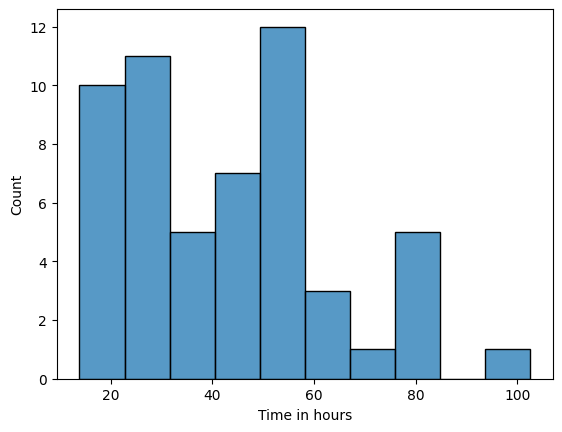

In [392]:
import matplotlib.pyplot as plt
import seaborn as sns

system_times = stats.total_times
system_times_min = [time_to_minutes(time) for time in system_times]
system_times_hours = [time / 60 for time in system_times_min]



# Plot the histogram
sns.histplot(system_times_hours, bins=10)
plt.xlabel('Time in hours')


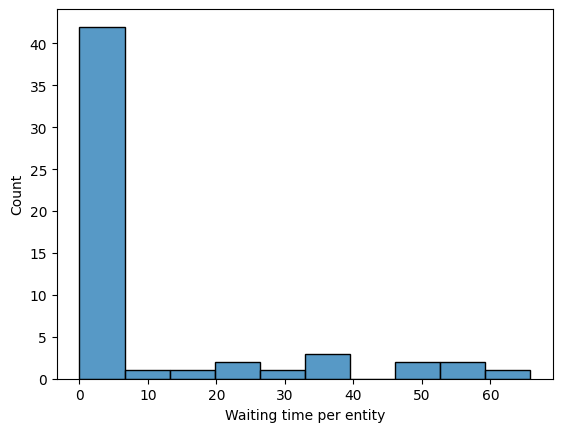

In [393]:
waiting_times = stats.waiting_times
waiting_times_min = [time_to_minutes(time) for time in waiting_times]
waiting_times_hours = [time / 60 for time in waiting_times_min]

sns.histplot(waiting_times_hours, bins=10)
plt.xlabel('Waiting time per entity');

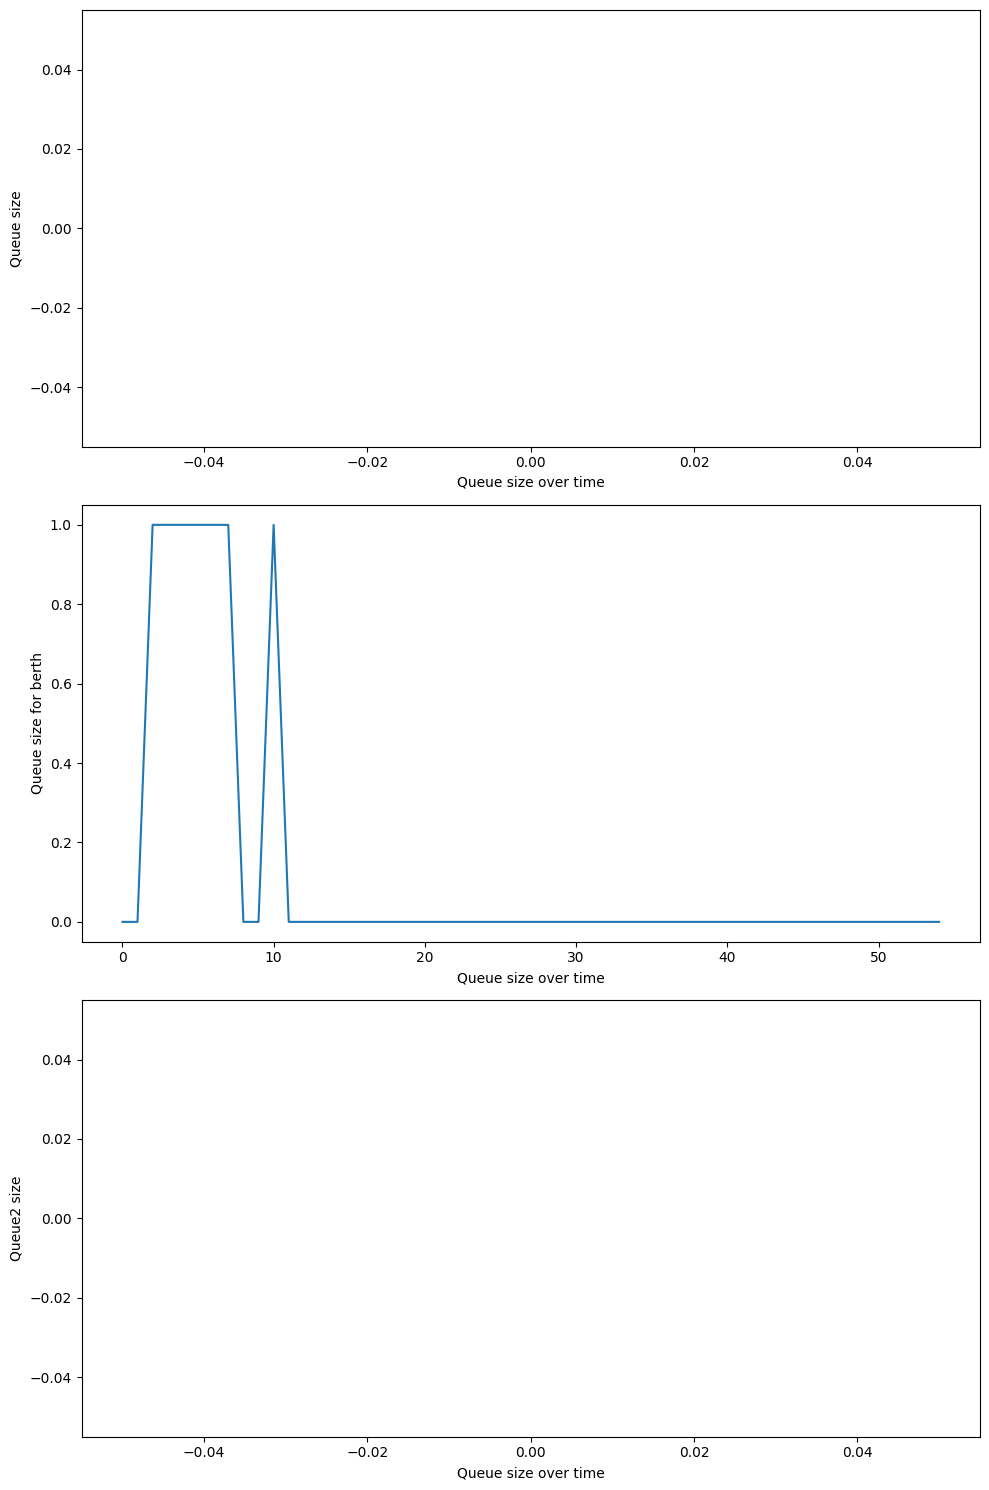

In [391]:
resource_queue = stats.queue_sizes["berth"]
resource_queue1 = stats.queue_sizes["berth_type1"]
resource_queue2 = stats.queue_sizes["berth_type2"]

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot 1: Queue size over time
axs[0].plot(range(len(resource_queue)), resource_queue)
axs[0].set_ylabel('Queue size')
axs[0].set_xlabel('Queue size over time')

# Plot 2: System times histogram
axs[1].plot(range(len(resource_queue1)), resource_queue1)
axs[1].set_ylabel('Queue size for berth')
axs[1].set_xlabel('Queue size over time')

# Plot 3: Waiting times histogram
axs[2].plot(range(len(resource_queue2)), resource_queue2)
axs[2].set_ylabel('Queue2 size')
axs[2].set_xlabel('Queue size over time')

plt.tight_layout()
plt.show()

In [300]:
import json

def count_code_lines(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)
    
    code_lines = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_lines += len(cell['source'])
    
    return code_lines

notebook_path = 'DES.ipynb'
code_lines = count_code_lines(notebook_path)
print(f"Total lines of code: {code_lines}")

Total lines of code: 748
